In [1]:

! pip install pytorch-lightning
! pip install pytorch-lightning-bolts==0.2.5rc1


[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
ERROR: Could not find a version that satisfies the requirement pytorch-lightning-bolts==0.2.5rc1 (from versions: 0.1.0, 0.1.1, 0.2.0, 0.2.1, 0.2.2, 0.2.3, 0.2.4, 0.2.5, 0.3.0, 0.3.1, 0.3.2, 0.3.2.post0, 0.3.2.post1)
ERROR: No matching distribution found for pytorch-lightning-bolts==0.2.5rc1

[notice] A new release of pip available: 22.2.2 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


#### First 4 elements
The main 4 elements of a VAE are:
- encoder
- decoder
- mu
- sigma

mu, sigma are the parameters for the distributions in our formula.

Note: in our notation we say $q(z|x)$ where we assume $q$ to be a neural network. However, q is a neural network that DOES NOT GENERATE z. Instead it generates parameters FOR a distribution OVER z.

In [2]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pl_bolts/utils/warnings.py:30: UserWarning: You want to use `wandb` which is not installed yet, install it with `pip install wandb`.
  stdout_func(


#### Sample z

In Lightning we define the model interactions and the core algorithm in the training_step.

For EDUCATIONAL purposes only, we are adding the training_step to the lightning module here instead of in the original class definition

The VAE algorithm goes like this:

1. Sample z

In [3]:
vae = VAE()

In [4]:
# DATA
# we're pretending to have an image from cifar-10 (3 channels, 32x32 pixels)
x = torch.rand(1, 3, 32, 32)

print('image shape:', x.shape)

# GET Q(z|x) PARAMETERS
# encode x to get the mu and variance parameters
x_encoded = vae.encoder(x)
mu, log_var = vae.fc_mu(x_encoded), vae.fc_var(x_encoded)

print('mu:', mu.shape)
print('log_var:', log_var.shape)

# SAMPLE Z from Q(Z|x)
std = torch.exp(log_var / 2)
q = torch.distributions.Normal(mu, std)
z = q.rsample()

print('z shape:', z.shape)

image shape: torch.Size([1, 3, 32, 32])
mu: torch.Size([1, 256])
log_var: torch.Size([1, 256])
z shape: torch.Size([1, 256])


In [5]:
zero = torch.zeros_like(mu)
one = torch.ones_like(std)
p = torch.distributions.Normal(zero, one)

#### decoding

The second part is reconstruction.

The decoder is going to take as input $z$ and it will generate PARAMETERS for a distribution from which to sample a reconstruction.

Note: Most tutorials use MNIST so the decoder generates BERNOULLI variables which can be used in a bernoulli distribution to sample a value for each pixel.

That's right, the decoder generates distribution parameters FOR EACH pixel. And since most tutorials use MNIST the outputs of the decoder will LOOK like a digit because those parameters are in the range 0-1 (which happens to be the same for black and white images).


But in our case, we'll actually use CIFAR-10 which are color images... so we need to do something more realistic:


In [6]:
x_hat = vae.decoder(z)
print(x_hat.shape)

torch.Size([1, 3, 32, 32])


#### reconstruction loss 

You'll likely see the reconstruction loss using MSE like this in most tutorials about autoencoders.

However, MSE DOES not apply to Variational autoencoders

In [7]:
recon_loss = F.mse_loss(x_hat, x, reduction='none')
recon_loss = recon_loss.sum(-1).sum(-1).sum(-1)
print('wrong reconstruction loss', recon_loss)

wrong reconstruction loss tensor([3358.1484], grad_fn=<SumBackward1>)


Instead, the output of the decoder represents parameters for a distribution.

When the images are MNIST, the parameters (decoder output) can be considered bernoullis and thus you can use the pixel values of MNIST (because they are ones and zeros) to calculate the cross entropy (which is the "reconstruction loss").

But when dealing with color images, it is prefered to model each parameter out of the decoder as a gaussian.

In [8]:
# get the PARAMETERS for P(x|z)
x_hat = vae.decoder(z)
print('we have these many parameters for a distribution:', x_hat.shape)

# compute the probability of x under this n-dimensional distribution
log_scale = nn.Parameter(torch.Tensor([0.0]))
scale = torch.exp(log_scale)
dist = torch.distributions.Normal(x_hat, scale)
log_pxz = dist.log_prob(x)

print(log_pxz.shape)

# sum across channels, and all pixels (width, height)
# this gives the log probability of THIS particular IMAGE
log_pxz = log_pxz.sum(dim=(1, 2, 3))
print(log_pxz.shape)
print('reconstruction loss:', log_pxz.item())

recon_loss = log_pxz

we have these many parameters for a distribution: torch.Size([1, 3, 32, 32])
torch.Size([1, 3, 32, 32])
torch.Size([1])
reconstruction loss: -4502.0537109375


#### kl divergence

Next we'll define the second term of the loss which is the KL divergence.

Now, we don't want to compute the KL divergence analytically, so we'll instead use the monte carlo estimate.

$$
= \mathbb{E}_{q}  \log \frac{q(z|x)}{p(z)}\\
= \mathbb{E}_{q} [\log q(z|x) - \log{p(z)}]
$$

To code this, we'll need to be able to get the probability of z under each of $p(z)$ and $q(z|x)$.

This means we don't need to know what the distribution is, but only sample from it.


In [9]:
# 1. define the first two probabilities (in this case Normal for both)
p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
q = torch.distributions.Normal(mu, std)

# 2. get the probabilities from the equation
log_qzx = q.log_prob(z)
log_pz = p.log_prob(z)

print(log_qzx.shape, log_pz.shape)

# 3. calculate the KL
kl = (log_qzx - log_pz)

# 4. this bit is a bit tricky. Since these are log probabilities
# we can sum all the individual dimensions to give us the multi-dimensional
# probability
kl = kl.sum(-1)
print(kl)

torch.Size([1, 256]) torch.Size([1, 256])
tensor([24.8270], grad_fn=<SumBackward1>)


#### ELBO

So, the full elbo is:

In [10]:
elbo = (kl - recon_loss)
print('kl:', kl.mean())
print('log likelihood (reconstruction loss):', recon_loss.mean())
print('elbo: ', elbo.mean())

kl: tensor(24.8270, grad_fn=<MeanBackward0>)
log likelihood (reconstruction loss): tensor(-4502.0537, grad_fn=<MeanBackward0>)
elbo:  tensor(4526.8809, grad_fn=<MeanBackward0>)


# Full Implementation
So, the full implementation is as follows.

In [11]:
(a, b), c = (1, 2), 3

print(a, b, c)

1 2 3


In [12]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional as F
from pl_bolts.models.autoencoders.components import (
    resnet18_decoder,
    resnet18_encoder,
)

class VAE(pl.LightningModule):
    def __init__(self, enc_out_dim=512, latent_dim=256, input_height=32):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.encoder = resnet18_encoder(False, False)
        self.decoder = resnet18_decoder(
            latent_dim=latent_dim, 
            input_height=input_height, 
            first_conv=False, 
            maxpool1=False
        )

        # for one-hot encoded CIFAR labels
        self.fc = nn.Linear(10, enc_out_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim * 2, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim * 2, latent_dim)

        # for the gaussian likelihood
        self.log_scale = nn.Parameter(torch.Tensor([0.0]))

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale)
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2, 3))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        (x, x_label), _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        x_label_encoded = self.fc(x_label)
        x_encoded = torch.cat([x_encoded, x_label_encoded], dim=1)
        
        # print("Shape of x_encoded:", x_encoded.shape)
        # return 
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, self.log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - recon_loss)
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(), 
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

    def forw_encoder(self, x):

        x, x_label = x
        x_encoded = self.encoder(x)
        x_label_encoded = self.fc(x_label)
        x_encoded = torch.cat([x_encoded, x_label_encoded], dim=1)
    
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        return mu, log_var
    
    def forw_decoder(self, mu, log_var):
        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample()

        # decoded 
        x_hat = vae.decoder(z)

        return x_hat

        

Let's use CIFAR-10 already split up and transformed.

The Lightning Datamodule has 3 dataloaders, train, val, test

In [13]:
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import CIFAR10
from pytorch_lightning import LightningDataModule
# import dataloader
from torch.utils.data import DataLoader

class CIFAR10WithLabelsDataset(Dataset):
    def __init__(self, cifar10_dataset):
        self.cifar10_dataset = cifar10_dataset
        self.num_classes = 10

    def __len__(self):
        return len(self.cifar10_dataset)

    def __getitem__(self, idx):
        image, label = self.cifar10_dataset[idx]
        label_tensor = torch.tensor(label, dtype=torch.int64)
        
        # One-hot encoding the label
        one_hot_label = F.one_hot(label_tensor, num_classes=self.num_classes).float()
        
        return (image, one_hot_label), label

class CIFAR10DataModule(LightningDataModule):
    def __init__(self, data_dir: str = "./data", batch_size: int = 256, num_workers: int = 4):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
            # use cifar normalization
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
            
            

        ])

    def setup(self, stage=None):
        cifar10_train = CIFAR10(self.data_dir, train=True, download=True, transform=self.transform)
        cifar10_val = CIFAR10(self.data_dir, train=False, download=True, transform=self.transform)
        self.cifar10_train = CIFAR10WithLabelsDataset(cifar10_train)
        self.cifar10_val = CIFAR10WithLabelsDataset(cifar10_val)

    def train_dataloader(self):
        return DataLoader(self.cifar10_train, batch_size=self.batch_size, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.cifar10_val, batch_size=self.batch_size, num_workers=self.num_workers)

# # Example usage


# x, y = cifar10_data.train_dataloader().dataset[0]


Now we train!

In [14]:
pl.seed_everything(1234)


cifar10_data = CIFAR10DataModule(batch_size=32)
cifar10_data.setup()


vae = VAE()

trainer = pl.Trainer(gpus=1, max_epochs=30)


Global seed set to 1234


Files already downloaded and verified
Files already downloaded and verified


GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [15]:

trainer.fit(vae, datamodule=cifar10_data)

/home/shivam13juna/Documents/virtual_envs/mlo/lib/python3.10/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping validation loop
  warnings.warn(*args, **kwargs)


In [ ]:
# save vae
torch.save(vae.state_dict(), "vae.pt")

## Plot an image

In [ ]:
mu.shape

torch.Size([1, 256])

In [ ]:
# extract data from cifar10
x, y = cifar10_data.train_dataloader().dataset[1]

In [ ]:
mu, log_var = vae.forw_encoder((x[0].unsqueeze(0), x[1].unsqueeze(0)))
mu = mu.squeeze(0)
log_var = log_var.squeeze(0)

In [ ]:
std = torch.exp(log_var * 0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


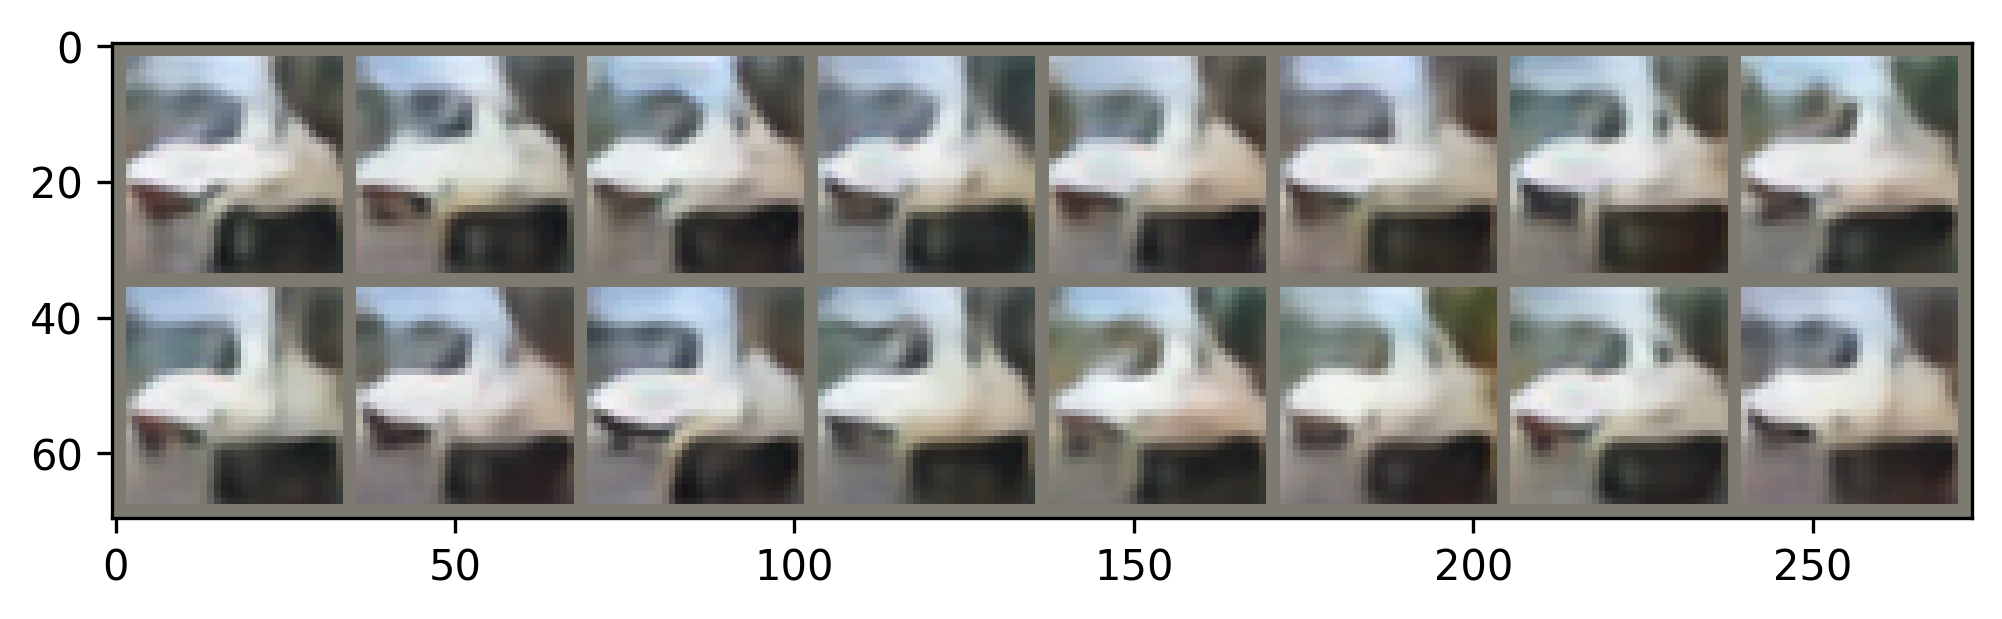

In [ ]:
from matplotlib.pyplot import imshow, figure
import numpy as np
from torchvision.utils import make_grid
from pl_bolts.transforms.dataset_normalizations import cifar10_normalization
figure(figsize=(8, 3), dpi=300)

# Z COMES FROM NORMAL(0, 1)
num_preds = 16
p = torch.distributions.Normal(mu, std)
z = p.rsample((num_preds,))

# SAMPLE IMAGES
with torch.no_grad():
    pred = vae.decoder(z.to(vae.device)).cpu()

# UNDO DATA NORMALIZATION
normalize = cifar10_normalization()
mean, std = np.array(normalize.mean), np.array(normalize.std)
img = make_grid(pred).permute(1, 2, 0).numpy() * std + mean

# PLOT IMAGES
imshow(img);